/home/ubuntu0/miniconda3/envs/glue2_scib/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ubuntu0/miniconda3/envs/glue2_scib/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


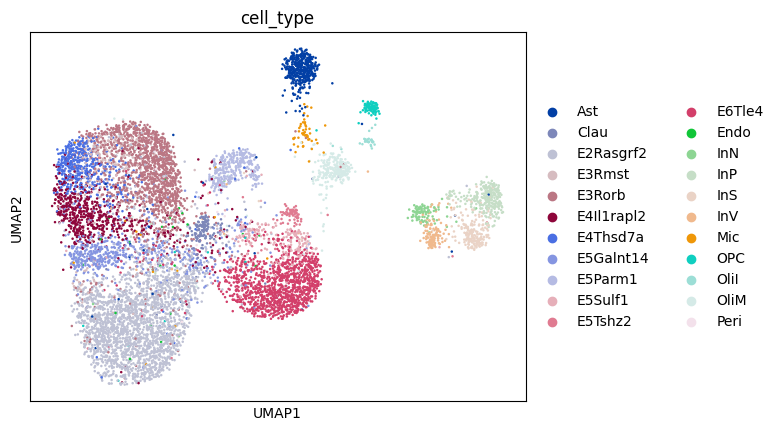

In [1]:
import anndata as ad 
import os
import pandas as pd 
import scglue 
import scanpy as sc 
#generate rna


#generate rna 
# rna = ad.read_h5ad('/home/ubuntu0/scBasset/Chen-2019-RNA.h5ad')
# rna.layers["counts"] = rna.X.copy()

# #select high expressive genes as in the tutorial the number 2000
# sc.pp.highly_variable_genes(rna, n_top_genes=60000, flavor="seurat_v3")

# sc.pp.normalize_total(rna)
# sc.pp.log1p(rna)
# sc.pp.scale(rna)
# sc.tl.pca(rna, n_comps=100, svd_solver="auto")

# sc.pp.neighbors(rna, metric="cosine")
# sc.tl.umap(rna)
# sc.pl.umap(rna,color='cell_type')

# scglue.data.get_gene_annotation(
#     rna, gtf="/home/ubuntu0/GLUE/evaluation/workflow/scripts/gencode.vM25.chr_patch_hapl_scaff.annotation.gtf.gz",
#     gtf_by="gene_name"
# )
rna=ad.read_h5ad('unfiltered_rna.h5ad')

In [2]:
# rna.write_h5ad('unfiltered_rna.h5ad')

In [3]:
#get atac0,atac1,atac2
path='2024-01-31-22_55_35'
atacl=[]
guidancel=[]
for i in range(3):
    atac=ad.read_h5ad('2024-01-31-22_55_35data/atac'+str(i)+'.h5ad')
    scglue.data.lsi(atac, n_components=100, n_iter=15)#enable lsi embedding
    split = atac.var_names.str.split(r"[:-]")
    atac.var["chrom"] = atac.var['chr']
    atac.var["chromStart"] = atac.var['start']
    atac.var["chromEnd"] = atac.var['end']
    guidance=scglue.genomics.rna_anchored_guidance_graph(rna, atac)
    atac.obsm['proj']=pd.read_csv(path+'scb_embedding/scb'+str(i)+'.csv',index_col=0).values #add scbasset embedding
    atacl.append(atac)
    guidancel.append(guidance)
sc.pp.subsample(rna,n_obs=4000,random_state=42) #filter rna here 

/home/ubuntu0/miniconda3/envs/glue2_scib/lib/python3.8/site-packages/scglue/num.py:289: RuntimeWarning: divide by zero encountered in divide
  idf = X.shape[0] / X.sum(axis=0)
window_graph: 100%|█████████████████████████████████████████| 28930/28930 [00:00<00:00, 41267.50it/s]
/home/ubuntu0/miniconda3/envs/glue2_scib/lib/python3.8/site-packages/scglue/num.py:289: RuntimeWarning: divide by zero encountered in divide
  idf = X.shape[0] / X.sum(axis=0)
window_graph: 100%|█████████████████████████████████████████| 28930/28930 [00:00<00:00, 32856.02it/s]
/home/ubuntu0/miniconda3/envs/glue2_scib/lib/python3.8/site-packages/scglue/num.py:289: RuntimeWarning: divide by zero encountered in divide
  idf = X.shape[0] / X.sum(axis=0)
window_graph: 100%|█████████████████████████████████████████| 28930/28930 [00:00<00:00, 29257.79it/s]


In [4]:
import scglue
from itertools import chain
import networkx as nx 
def train_glue(rna,atac,input_representation,guidance):
     
    #pca rna and lsi atac
    scglue.models.configure_dataset(rna,'NB',use_highly_variable=True,use_layer='counts',use_rep='X_pca')

    scglue.models.configure_dataset(atac,'NB',use_highly_variable=True,use_rep=input_representation)

    guidance_hvf=guidance.subgraph(chain(rna.var.query('highly_variable').index,atac.var.query('highly_variable').index)).copy()

    glue=scglue.models.fit_SCGLUE({'rna':rna,'atac':atac},guidance_hvf,fit_kws={'directory':'glue'})
    return glue,guidance_hvf


In [5]:
import os 
os.makedirs(path+'glue')

In [6]:
import warnings 
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt 
import pandas as pd 

def run_scib(atac,proj):
    import scib
    clisi=False
    ilisi=False
    graph_connect=False
    hvg=False
    atac.obs['cell_type']=atac.obs['cell_type'].astype('category')
    atac.obs['batch']=0
    atac.obs['batch']=atac.obs['batch'].astype('category')
    out=scib.metrics.metrics(atac, atac, batch_key='batch', label_key='cell_type', embed=proj, cluster_key='cluster', cluster_nmi=None, ari_=True, nmi_=True, nmi_method='arithmetic', nmi_dir=None, silhouette_=True, si_metric='euclidean', pcr_=True, cell_cycle_=False, organism='human', hvg_score_=hvg, isolated_labels_=True, isolated_labels_f1_=False, isolated_labels_asw_=True, n_isolated=True, graph_conn_=graph_connect, trajectory_=False, kBET_=False, lisi_graph_=False, ilisi_=ilisi, clisi_=clisi, subsample=0.5, n_cores=1, type_=None, verbose=False)
    return out

def metric_res(dflist,data_namelist):
    gmetrics=pd.concat(dflist,axis='columns')
    gmetrics=gmetrics.set_axis(data_namelist,axis='columns')

    bio=gmetrics.loc[['NMI_cluster/label','ARI_cluster/label','ASW_label','cell_cycle_conservation','isolated_label_F1','isolated_label_silhouette','hvg_overlap','trajectory'],:,]
    bio=bio.T
    bio=bio.drop(columns=['hvg_overlap','trajectory','cell_cycle_conservation'])
    #bio mean 
    bio['bio']=bio.mean(axis=1)
    bio=bio.style.background_gradient(cmap = 'Blues')
    return bio,bio_style


def plot_dx(dx_lsi,dx_scb,save_pth):

    fig,ax=plt.subplots(1,2,figsize=(20,6),gridspec_kw={'wspace':0.9})
    sub=sns.lineplot(x='n_meta',y='consistency',data=dx_lsi,ax=ax[0],label='baseline').axhline(y=0.05,c='darkred',ls='--')
    ax[0].set_title('baseline consistency score')
    ax[0].get_legend().remove()
    sns.lineplot(x='n_meta',y='consistency',data=dx_scb,ax=ax[1],label='scglue with scbasset embedding(input)').axhline(y=0.05,c='darkred',ls='--')
    ax[1].set_title('scglue3_scbasset consistency score')
    ax[1].get_legend().remove()

    plt.savefig(save_pth)
    
def plot_dx_together(dx_lsi,dx_scb,save_pth):
    dx_list=[]
    dx_list.append(dx_lsi.T)
    dx_list.append(dx_scb.T)
    dx_metrics = pd.concat(dx_list,axis='rows')
    dx_metrics = dx_metrics.T
    dx_metrics = dx_metrics.iloc[:,[0,1,3]]
    dx_metrics = dx_metrics.set_axis(['n_meta cells','baseline consistency','scglue3_scbasset consistency'],axis='columns')
    dx_metrics = dx_metrics.set_index('n_meta cells')
    ax=dx_metrics.plot(figsize=(8,6))
    ax.set_ylabel('consistency')
    ax.set_xlabel('n-meta cells')
    plt.title('scglue consistency score metrics')
    plt.savefig(save_pth)

In [8]:
os.makedirs(path+'hvfguidance',exist_ok=True)

In [9]:
path='2024-01-31-22_55_35'
bio_result=[]
name_list=[]
for i in range(3):# to train glue embedding
    atac=atacl[i]
    guidance=guidancel[i]
    
    glue_scb,guidance_hvf_scb=train_glue(rna,atac,'proj',guidance)
    glue_scb.save(path+'glue/scb'+str(i)+'.dill')
    nx.write_graphml(guidance_hvf_scb,path+'hvfguidance/'+'hvfscb'+str(i))
    
    glue_lsi,guidance_hvf_lsi=train_glue(rna,atac,'X_lsi',guidance)
    glue_lsi.save(path+'glue/lsi'+str(i)+'.dill')
    nx.write_graphml(guidance_hvf_lsi,path+'hvfguidance/'+'hvflsi'+str(i))
    


[INFO] fit_SCGLUE: Pretraining SCGLUE model...
[INFO] autodevice: Using GPU 0 as computation device.
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 49939
[INFO] SCGLUEModel: Setting `max_epochs` = 427
[INFO] SCGLUEModel: Setting `patience` = 36
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 18
[INFO] SCGLUETrainer: Using training directory: "glue/pretrain"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.444, 'g_kl': 0.001, 'g_elbo': 0.445, 'x_rna_nll': 0.115, 'x_rna_kl': 0.002, 'x_rna_elbo': 0.117, 'x_atac_nll': 0.055, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.056, 'dsc_loss': 0.692, 'vae_loss': 0.191, 'gen_loss': 0.156}, val={'g_nll': 0.44, 'g_kl': 0.002, 'g_elbo': 0.442, 'x_rna_nll': 0.116, 'x_rna_kl': 0.002, 'x_rna_elbo': 0.118, 'x_atac_nll': 0.058, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.058, 'ds

2024-02-01 20:02:33,988 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "98"...
[INFO] EarlyStopping: Restoring checkpoint "98"...
[INFO] fit_SCGLUE: Estimating balancing weight...
[INFO] estimate_balancing_weight: Clustering cells...
[INFO] estimate_balancing_weight: Matching clusters...
[INFO] estimate_balancing_weight: Matching array shape = (16, 11)...
[INFO] estimate_balancing_weight: Estimating balancing weight...
[INFO] fit_SCGLUE: Fine-tuning SCGLUE model...
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 49939
[INFO] SCGLUEModel: Setting `align_burnin` = 72
[INFO] SCGLUEModel: Setting `max_epochs` = 427
[INFO] SCGLUEModel: Setting `patience` = 36
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 18
[INFO] SCGLUETrainer: Using training directory: "glue/fine-tune"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.4, 'g_

2024-02-01 20:12:23,412 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "132"...
[INFO] EarlyStopping: Restoring checkpoint "132"...


[WARNING] configure_dataset: `configure_dataset` has already been called. Previous configuration will be overwritten!
[WARNING] configure_dataset: `configure_dataset` has already been called. Previous configuration will be overwritten!


[INFO] fit_SCGLUE: Pretraining SCGLUE model...
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 49939
[INFO] SCGLUEModel: Setting `max_epochs` = 427
[INFO] SCGLUEModel: Setting `patience` = 36
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 18
[INFO] SCGLUETrainer: Using training directory: "glue/pretrain"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.444, 'g_kl': 0.002, 'g_elbo': 0.445, 'x_rna_nll': 0.115, 'x_rna_kl': 0.002, 'x_rna_elbo': 0.117, 'x_atac_nll': 0.055, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.056, 'dsc_loss': 0.692, 'vae_loss': 0.191, 'gen_loss': 0.156}, val={'g_nll': 0.441, 'g_kl': 0.002, 'g_elbo': 0.442, 'x_rna_nll': 0.117, 'x_rna_kl': 0.002, 'x_rna_elbo': 0.119, 'x_atac_nll': 0.058, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.059, 'dsc_loss': 0.695, 'vae_loss': 0.195, 'gen_loss': 0.16},

2024-02-01 20:19:19,305 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "98"...
[INFO] EarlyStopping: Restoring checkpoint "98"...
[INFO] fit_SCGLUE: Estimating balancing weight...
[INFO] estimate_balancing_weight: Clustering cells...
[INFO] estimate_balancing_weight: Matching clusters...
[INFO] estimate_balancing_weight: Matching array shape = (15, 10)...
[INFO] estimate_balancing_weight: Estimating balancing weight...
[INFO] fit_SCGLUE: Fine-tuning SCGLUE model...
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 49939
[INFO] SCGLUEModel: Setting `align_burnin` = 72
[INFO] SCGLUEModel: Setting `max_epochs` = 427
[INFO] SCGLUEModel: Setting `patience` = 36
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 18
[INFO] SCGLUETrainer: Using training directory: "glue/fine-tune"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.405, '

2024-02-01 20:27:55,287 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "132"...
[INFO] EarlyStopping: Restoring checkpoint "132"...


[WARNING] configure_dataset: `configure_dataset` has already been called. Previous configuration will be overwritten!


[INFO] fit_SCGLUE: Pretraining SCGLUE model...
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 49723
[INFO] SCGLUEModel: Setting `max_epochs` = 427
[INFO] SCGLUEModel: Setting `patience` = 36
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 18
[INFO] SCGLUETrainer: Using training directory: "glue/pretrain"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.443, 'g_kl': 0.002, 'g_elbo': 0.445, 'x_rna_nll': 0.115, 'x_rna_kl': 0.002, 'x_rna_elbo': 0.117, 'x_atac_nll': 0.055, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.056, 'dsc_loss': 0.692, 'vae_loss': 0.191, 'gen_loss': 0.156}, val={'g_nll': 0.441, 'g_kl': 0.002, 'g_elbo': 0.442, 'x_rna_nll': 0.116, 'x_rna_kl': 0.002, 'x_rna_elbo': 0.118, 'x_atac_nll': 0.055, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.056, 'dsc_loss': 0.695, 'vae_loss': 0.192, 'gen_loss': 0.157}

2024-02-01 20:34:50,437 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "111"...
[INFO] EarlyStopping: Restoring checkpoint "111"...
[INFO] fit_SCGLUE: Estimating balancing weight...
[INFO] estimate_balancing_weight: Clustering cells...
[INFO] estimate_balancing_weight: Matching clusters...
[INFO] estimate_balancing_weight: Matching array shape = (14, 11)...
[INFO] estimate_balancing_weight: Estimating balancing weight...
[INFO] fit_SCGLUE: Fine-tuning SCGLUE model...
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 49723
[INFO] SCGLUEModel: Setting `align_burnin` = 72
[INFO] SCGLUEModel: Setting `max_epochs` = 427
[INFO] SCGLUEModel: Setting `patience` = 36
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 18
[INFO] SCGLUETrainer: Using training directory: "glue/fine-tune"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.4, '

2024-02-01 20:43:23,088 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "137"...
[INFO] EarlyStopping: Restoring checkpoint "137"...


[WARNING] configure_dataset: `configure_dataset` has already been called. Previous configuration will be overwritten!
[WARNING] configure_dataset: `configure_dataset` has already been called. Previous configuration will be overwritten!


[INFO] fit_SCGLUE: Pretraining SCGLUE model...
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 49723
[INFO] SCGLUEModel: Setting `max_epochs` = 427
[INFO] SCGLUEModel: Setting `patience` = 36
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 18
[INFO] SCGLUETrainer: Using training directory: "glue/pretrain"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.444, 'g_kl': 0.002, 'g_elbo': 0.446, 'x_rna_nll': 0.115, 'x_rna_kl': 0.002, 'x_rna_elbo': 0.117, 'x_atac_nll': 0.055, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.056, 'dsc_loss': 0.692, 'vae_loss': 0.191, 'gen_loss': 0.156}, val={'g_nll': 0.441, 'g_kl': 0.002, 'g_elbo': 0.443, 'x_rna_nll': 0.116, 'x_rna_kl': 0.002, 'x_rna_elbo': 0.118, 'x_atac_nll': 0.055, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.056, 'dsc_loss': 0.695, 'vae_loss': 0.192, 'gen_loss': 0.157}

2024-02-01 20:50:16,246 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "111"...
[INFO] EarlyStopping: Restoring checkpoint "111"...
[INFO] fit_SCGLUE: Estimating balancing weight...
[INFO] estimate_balancing_weight: Clustering cells...
[INFO] estimate_balancing_weight: Matching clusters...
[INFO] estimate_balancing_weight: Matching array shape = (14, 9)...
[INFO] estimate_balancing_weight: Estimating balancing weight...
[INFO] fit_SCGLUE: Fine-tuning SCGLUE model...
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 49723
[INFO] SCGLUEModel: Setting `align_burnin` = 72
[INFO] SCGLUEModel: Setting `max_epochs` = 427
[INFO] SCGLUEModel: Setting `patience` = 36
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 18
[INFO] SCGLUETrainer: Using training directory: "glue/fine-tune"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.402, 

2024-02-01 20:58:46,036 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "137"...
[INFO] EarlyStopping: Restoring checkpoint "137"...


[WARNING] configure_dataset: `configure_dataset` has already been called. Previous configuration will be overwritten!


[INFO] fit_SCGLUE: Pretraining SCGLUE model...
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 49723
[INFO] SCGLUEModel: Setting `max_epochs` = 427
[INFO] SCGLUEModel: Setting `patience` = 36
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 18
[INFO] SCGLUETrainer: Using training directory: "glue/pretrain"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.444, 'g_kl': 0.002, 'g_elbo': 0.446, 'x_rna_nll': 0.115, 'x_rna_kl': 0.002, 'x_rna_elbo': 0.117, 'x_atac_nll': 0.055, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.056, 'dsc_loss': 0.691, 'vae_loss': 0.191, 'gen_loss': 0.156}, val={'g_nll': 0.443, 'g_kl': 0.002, 'g_elbo': 0.445, 'x_rna_nll': 0.116, 'x_rna_kl': 0.002, 'x_rna_elbo': 0.118, 'x_atac_nll': 0.055, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.056, 'dsc_loss': 0.699, 'vae_loss': 0.192, 'gen_loss': 0.157}

2024-02-01 21:05:41,749 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "111"...
[INFO] EarlyStopping: Restoring checkpoint "111"...
[INFO] fit_SCGLUE: Estimating balancing weight...
[INFO] estimate_balancing_weight: Clustering cells...
[INFO] estimate_balancing_weight: Matching clusters...
[INFO] estimate_balancing_weight: Matching array shape = (16, 10)...
[INFO] estimate_balancing_weight: Estimating balancing weight...
[INFO] fit_SCGLUE: Fine-tuning SCGLUE model...
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 49723
[INFO] SCGLUEModel: Setting `align_burnin` = 72
[INFO] SCGLUEModel: Setting `max_epochs` = 427
[INFO] SCGLUEModel: Setting `patience` = 36
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 18
[INFO] SCGLUETrainer: Using training directory: "glue/fine-tune"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.397,

2024-02-01 21:14:15,647 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "137"...
[INFO] EarlyStopping: Restoring checkpoint "137"...


[WARNING] configure_dataset: `configure_dataset` has already been called. Previous configuration will be overwritten!
[WARNING] configure_dataset: `configure_dataset` has already been called. Previous configuration will be overwritten!


[INFO] fit_SCGLUE: Pretraining SCGLUE model...
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 49723
[INFO] SCGLUEModel: Setting `max_epochs` = 427
[INFO] SCGLUEModel: Setting `patience` = 36
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 18
[INFO] SCGLUETrainer: Using training directory: "glue/pretrain"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.444, 'g_kl': 0.002, 'g_elbo': 0.446, 'x_rna_nll': 0.115, 'x_rna_kl': 0.002, 'x_rna_elbo': 0.117, 'x_atac_nll': 0.055, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.056, 'dsc_loss': 0.692, 'vae_loss': 0.191, 'gen_loss': 0.156}, val={'g_nll': 0.442, 'g_kl': 0.002, 'g_elbo': 0.443, 'x_rna_nll': 0.116, 'x_rna_kl': 0.002, 'x_rna_elbo': 0.118, 'x_atac_nll': 0.055, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.056, 'dsc_loss': 0.696, 'vae_loss': 0.192, 'gen_loss': 0.157}

2024-02-01 21:21:11,636 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "111"...
[INFO] EarlyStopping: Restoring checkpoint "111"...
[INFO] fit_SCGLUE: Estimating balancing weight...
[INFO] estimate_balancing_weight: Clustering cells...
[INFO] estimate_balancing_weight: Matching clusters...
[INFO] estimate_balancing_weight: Matching array shape = (15, 9)...
[INFO] estimate_balancing_weight: Estimating balancing weight...
[INFO] fit_SCGLUE: Fine-tuning SCGLUE model...
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 49723
[INFO] SCGLUEModel: Setting `align_burnin` = 72
[INFO] SCGLUEModel: Setting `max_epochs` = 427
[INFO] SCGLUEModel: Setting `patience` = 36
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 18
[INFO] SCGLUETrainer: Using training directory: "glue/fine-tune"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.402, 

2024-02-01 21:29:45,644 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "137"...
[INFO] EarlyStopping: Restoring checkpoint "137"...


In [10]:
#scib check
scib=[]
name_list=[]
for i in range(3):
    atac=atacl[i]
    glue_scb=scglue.models.load_model(path+'glue/scb'+str(i)+'.dill')
    glue_lsi=scglue.models.load_model(path+'glue/lsi'+str(i)+'.dill')
    atac.obsm['X_glue']=glue_lsi.encode_data('atac',atac)
    df1=run_scib(atac,'X_glue')
    atac.obsm['X_glue']=glue_scb.encode_data('atac',atac)
    df2=run_scib(atac,'X_glue')
    scib.append(df1)
    scib.append(df2)
    name_list.append('d'+str(i)+'lsi')
    name_list.append('d'+str(i)+'scbasset')
bio=metric_res(scib,name_list)

/home/ubuntu0/miniconda3/envs/glue2_scib/lib/python3.8/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
PC regression...


/home/ubuntu0/miniconda3/envs/glue2_scib/lib/python3.8/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(
/home/ubuntu0/miniconda3/envs/glue2_scib/lib/python3.8/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(


Isolated labels F1...
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Isolated labels ASW...


/home/ubuntu0/miniconda3/envs/glue2_scib/lib/python3.8/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
PC regression...


/home/ubuntu0/miniconda3/envs/glue2_scib/lib/python3.8/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(
/home/ubuntu0/miniconda3/envs/glue2_scib/lib/python3.8/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(


Variance contribution increased after integration!
Setting PCR comparison score to 0.
Isolated labels F1...
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Isolated labels ASW...


/home/ubuntu0/miniconda3/envs/glue2_scib/lib/python3.8/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
PC regression...


/home/ubuntu0/miniconda3/envs/glue2_scib/lib/python3.8/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(
/home/ubuntu0/miniconda3/envs/glue2_scib/lib/python3.8/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(


Isolated labels F1...
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Isolated labels ASW...


/home/ubuntu0/miniconda3/envs/glue2_scib/lib/python3.8/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
PC regression...


/home/ubuntu0/miniconda3/envs/glue2_scib/lib/python3.8/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(
/home/ubuntu0/miniconda3/envs/glue2_scib/lib/python3.8/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(


Isolated labels F1...
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Isolated labels ASW...


/home/ubuntu0/miniconda3/envs/glue2_scib/lib/python3.8/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
PC regression...


/home/ubuntu0/miniconda3/envs/glue2_scib/lib/python3.8/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(
/home/ubuntu0/miniconda3/envs/glue2_scib/lib/python3.8/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(


Isolated labels F1...
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Isolated labels ASW...


/home/ubuntu0/miniconda3/envs/glue2_scib/lib/python3.8/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
PC regression...


/home/ubuntu0/miniconda3/envs/glue2_scib/lib/python3.8/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(
/home/ubuntu0/miniconda3/envs/glue2_scib/lib/python3.8/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(


Isolated labels F1...
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Compute neighbors on rep X_glue
Isolated labels ASW...


In [13]:
bio

,NMI_cluster/label,ARI_cluster/label,ASW_label,isolated_label_F1,isolated_label_silhouette,bio
d0lsi,0.495361,0.454859,0.506001,0.389654,0.491710,0.467517
d0scbasset,0.495361,0.454859,0.499139,0.323529,0.482583,0.451094
d1lsi,0.507868,0.457058,0.503679,0.403003,0.492673,0.472856
d1scbasset,0.507868,0.457058,0.503770,0.341859,0.483535,0.458818
d2lsi,0.503475,0.424021,0.502942,0.393062,0.491038,0.462908
d2scbasset,0.503475,0.424021,0.500188,0.324868,0.482608,0.447032


In [20]:

bio_df,bio=metric_res(scib,name_list)
bio_df['bio']=bio_df['bio'].round(2)
bio_df

,NMI_cluster/label,ARI_cluster/label,ASW_label,isolated_label_F1,isolated_label_silhouette,bio
d0lsi,0.495361,0.454859,0.506001,0.389654,0.491710,0.47
d0scbasset,0.495361,0.454859,0.499139,0.323529,0.482583,0.45
d1lsi,0.507868,0.457058,0.503679,0.403003,0.492673,0.47
d1scbasset,0.507868,0.457058,0.503770,0.341859,0.483535,0.46
d2lsi,0.503475,0.424021,0.502942,0.393062,0.491038,0.46
d2scbasset,0.503475,0.424021,0.500188,0.324868,0.482608,0.45


In [21]:
bio_df.to_csv(path+'bio.csv')

In [ ]:
plt.figure(dpi=120)


sns.heatmap(data=bio,
           cmap=plt.get_cmap('Greens'),
           annot=True
           )

plt.title('scib metrics')
plt.xlabel('metric type')
plt.ylabel('modified models')
plt.savefig('test_code_example/scib_heatmap.png',bbox_inches='tight')